In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from joblib import load
import missingno as msgn
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from joblib import Parallel, delayed
import torch
from pytorch_lightning.utilities.seed import isolate_rng
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import SymmetricMeanAbsolutePercentageError, R2Score
from captum.attr import IntegratedGradients

In [2]:
df = load("test_data.pickle")

### EDA

Общая информация про данные

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999992 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                999992 non-null  int64 
 1   session_id             999992 non-null  object
 2   date_service           999992 non-null  object
 3   session_start_date     999992 non-null  object
 4   session_end_date       999992 non-null  object
 5   session_length         999992 non-null  int64 
 6   session_status         999992 non-null  object
 7   segment                999992 non-null  object
 8   channel                999992 non-null  object
 9   subchannel             998097 non-null  object
 10  service_category       776154 non-null  object
 11  doctor_specialization  262912 non-null  object
 12  doctor_speciality      276145 non-null  object
 13  physiotherapy_type     95930 non-null   object
 14  diagnostics_type       106657 non-null  object
 15  labor

In [4]:
df.date_service = pd.to_datetime(df.date_service)
df.session_start_date = pd.to_datetime(df.session_start_date)
df.session_end_date = pd.to_datetime(df.session_end_date)

По info видим что где-то есть NaN, посмотрим в более графическом виде

<Axes: >

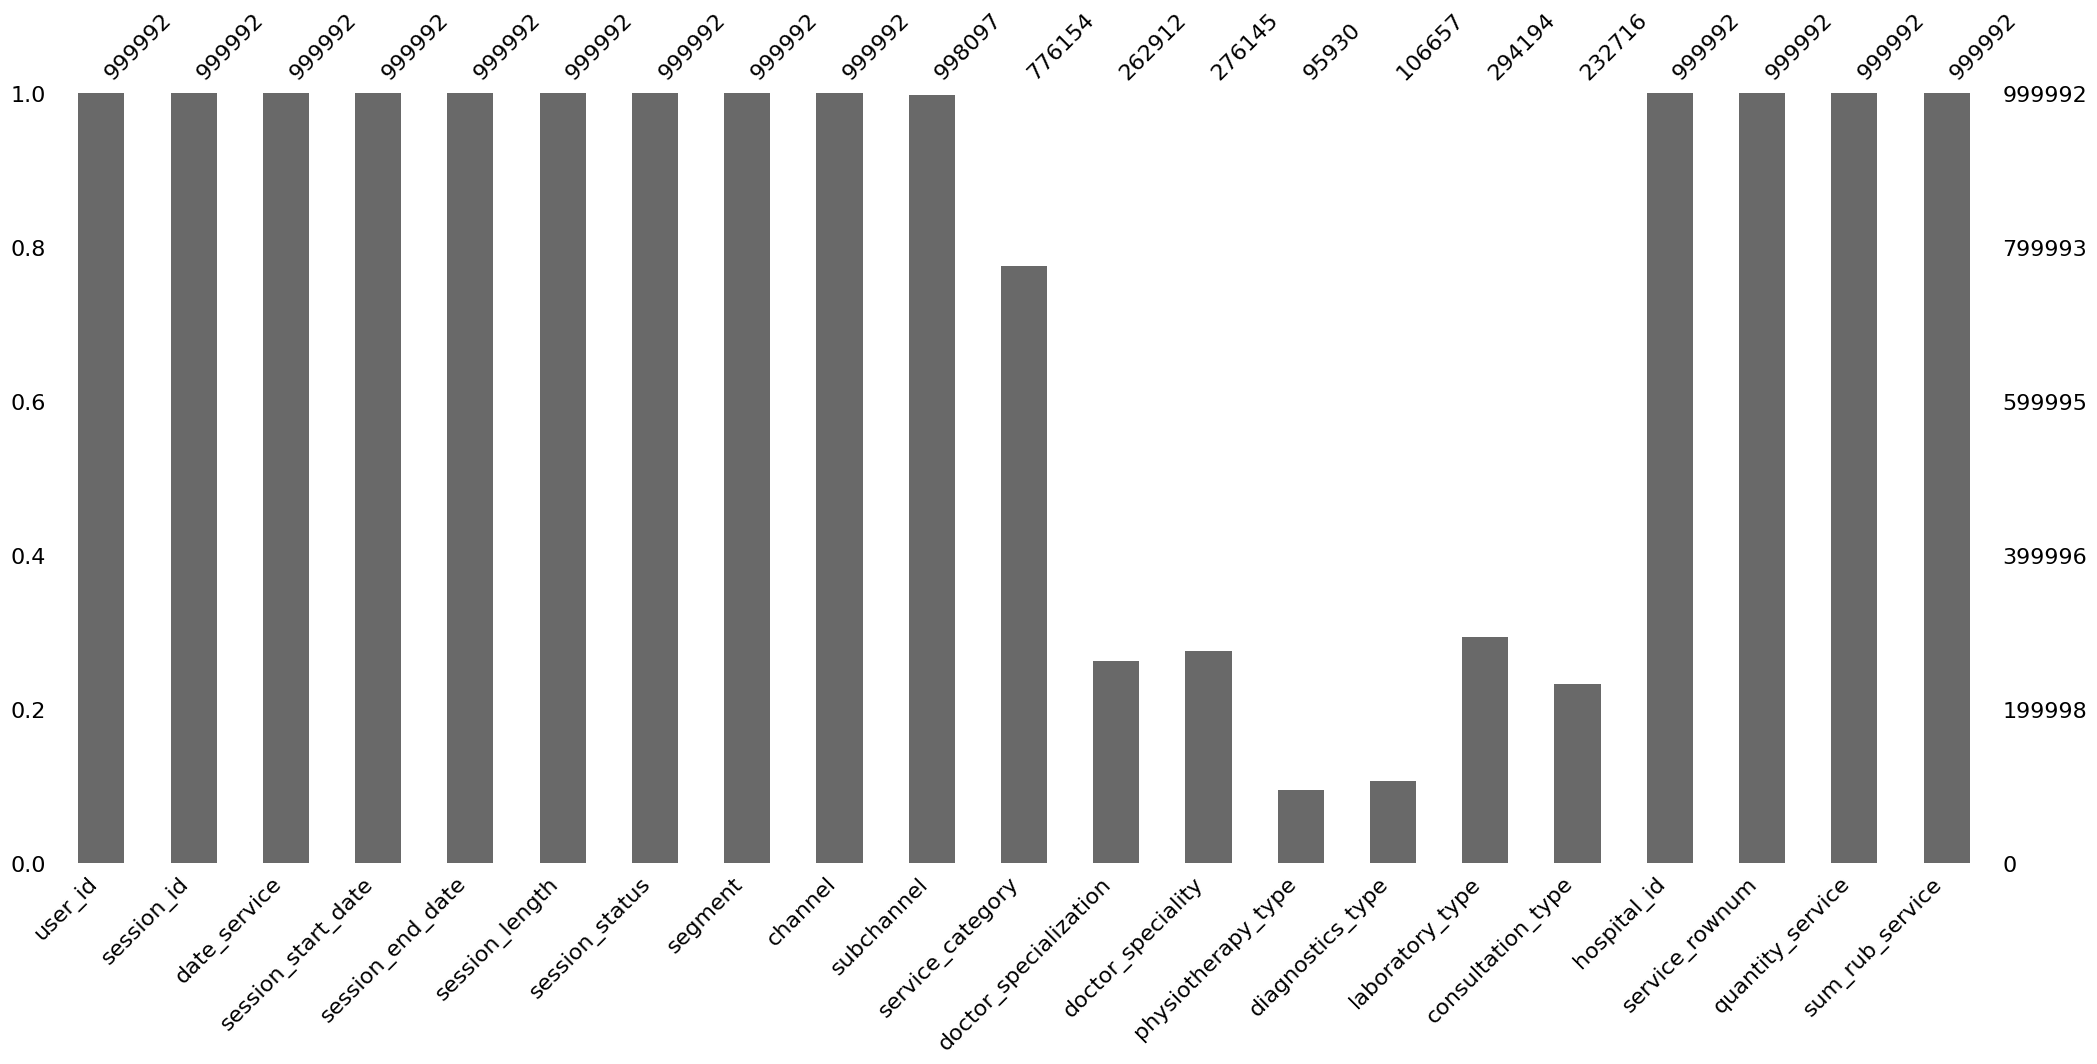

In [5]:
msgn.bar(df)

Пропусков много, но есть некоторые гипотезы, почему конкретно у этих колонок.

Просмотр значений различных object колонок

In [6]:
df.session_status.value_counts()

session_status
Completed      999159
In progress       833
Name: count, dtype: int64

In [7]:
df.segment.value_counts()

segment
Не КМ               986905
КМ                   12757
Цифровая клиника       330
Name: count, dtype: int64

In [8]:
df.channel.value_counts()

channel
Очно    978729
ТМ       10830
ПНД      10433
Name: count, dtype: int64

In [9]:
df.subchannel.value_counts()

subchannel
Поликлиника        648971
Лаборатория        293050
Стационар           34813
Моб. приложение     10830
Выездная служба     10433
Name: count, dtype: int64

In [10]:
df.service_category.value_counts()

service_category
Лабораторная диагностика        294194
Приемы или консультации         276145
Инструментальная диагностика    106657
Физиотерапия                     95930
Услуги сопровождения              3228
Name: count, dtype: int64

In [11]:
df.doctor_speciality.value_counts()

doctor_speciality
Врач-специалист    203200
Терапевт            64481
Стоматолог           5400
Педиатр              1870
Психолог             1194
Name: count, dtype: int64

In [12]:
df.doctor_specialization.value_counts()

doctor_specialization
Терапевт               64330
Невролог               31013
Акушер-гинеколог       25370
Отоларинголог          18894
Гастроэнтеролог        15866
Травматолог-ортопед    14006
Эндокринолог           13644
Хирург                 12215
Кардиолог              11450
Офтальмолог            10663
Уролог                 10636
Физиотерапевт           8309
Дерматолог              8141
Онколог                 6067
Колопроктолог           2691
Аллерголог              2356
Ревматолог              2299
Педиатр                 1869
Пульмонолог             1687
Инфекционист             746
Нефролог                 442
Нейрохирург              218
Name: count, dtype: int64

In [13]:
df.physiotherapy_type.value_counts()

physiotherapy_type
Массаж                 24209
Физио - элект.         18987
Физио - магнит.        17201
Иглорефлексотерапия     9302
Ман. терапия            8406
Физио - уз              7238
Физио - лазер.          5739
ЛФК                     4430
Физио - свет.            293
Физио - аэроз.            87
Физио - тепл.             38
Name: count, dtype: int64

In [14]:
df.diagnostics_type.value_counts()

diagnostics_type
УЗИ              50807
Рентген          23653
ЭКГ              13032
Эндоскопия        8160
МРТ               4407
Холтер, СМАД      2920
КТ                1794
ФВД               1105
Эл-физ. иссл.      779
Name: count, dtype: int64

In [15]:
df.laboratory_type.value_counts()

laboratory_type
Лаб. усл. - биохим.                        103818
Лаб. усл. - общекл.                         55321
Лаб. усл. - заб. мат.                       53975
Лаб. усл. - горм.                           15990
Лаб. усл. - м-скопия                        11877
Лаб. усл. - инфек.                          11819
Лаб. усл. - цитол.                           7704
Лаб. усл. - микроэл.                         7043
Лаб. усл. - бакт.                            6767
Лаб. усл. - ковид                            6473
Лаб. усл. - коаг.                            4716
Лаб. усл. - инфек. - гастроэнтеролог         1866
Лаб. усл. - гист.                            1658
Лаб. усл. - аутоант.                         1291
Лаб. усл. - онкол.                           1232
Лаб. усл. - гемат.                           1069
Лаб. усл. - аллерг.                           887
Лаб. усл. - вит.                              353
Лаб. усл. - гист. - гастроэнтеролог           267
Лаб. усл. - заб. мат. - гастроэнте

In [16]:
df.consultation_type.value_counts()

consultation_type
Первичный                  127022
Повторный                   99051
По результатам анализов      6643
Name: count, dtype: int64

Все категориальные значения не несут в себе каких-либо последовательностей, поэтому их можно смело закодировать через LabelEncoder, сначала выбрав метод как справиться с NaN

In [17]:
df[df.doctor_speciality.isna()].head()

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
0,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,5,1,220
1,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,6,1,244
2,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,7,1,216
3,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,8,1,454
4,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,9,1,229


Какая-то часть данных, в которых отсутствуют колонки тем или иным образом связаны с услугой. Логично, что если проводился рентген, то *doctor_speciality*, *laboratory_type*, etc. не указывается, то же самое и можно сказать про обратные ситуации.<br>
Значит можно сказать, что большая часть пропусков которые мы видели выше связанны именно с этим явлением.

In [18]:
df[(df.service_category.isna())]

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
8,100134420,100134420.2.1,2022-10-24,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,35002198,15,1,411
21,100134648,100134648.2.1,2022-08-25,2022-08-25,2022-09-19,26,Completed,Не КМ,ПНД,Выездная служба,...,NaN,NaN,NaN,NaN,NaN,NaN,135347812,1,1,2964
31,10018218,10018218.4.1,2023-01-20,2022-11-25,2023-01-24,61,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,136619018,34,1,414
32,10018218,10018218.4.1,2023-01-20,2022-11-25,2023-01-24,61,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,136619018,35,3,498
33,10018218,10018218.4.1,2023-01-20,2022-11-25,2023-01-24,61,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,136619018,36,1,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999989,142172786,142172786.1.1,2022-04-18,2022-04-14,2022-04-18,5,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,135163275,7,20,3146
999990,142172786,142172786.1.1,2022-04-18,2022-04-14,2022-04-18,5,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,135163275,8,15,3507
999991,142172786,142172786.1.1,2022-04-18,2022-04-14,2022-04-18,5,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,135163275,9,2,1383
999992,142172786,142172786.1.1,2022-04-18,2022-04-14,2022-04-18,5,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,135163275,10,13,2511


Однако тоже самое нельзя сказать про пропущенный service_category, в этом случае все колонки у нас NaN. Можно проверить более детально.

In [19]:
cols = ['consultation_type', 'laboratory_type', 'diagnostics_type', 'physiotherapy_type', 'doctor_specialization', 
        'doctor_speciality']

In [20]:
df[df.service_category.isna()][cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 223838 entries, 8 to 999993
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   consultation_type      1535 non-null   object
 1   laboratory_type        0 non-null      object
 2   diagnostics_type       0 non-null      object
 3   physiotherapy_type     0 non-null      object
 4   doctor_specialization  0 non-null      object
 5   doctor_speciality      0 non-null      object
dtypes: object(6)
memory usage: 12.0+ MB


In [21]:
df[(df.service_category.isna()) & (~df.consultation_type.isna())].consultation_type.value_counts()

consultation_type
Первичный    1105
Повторный     430
Name: count, dtype: int64

Очень странно, что консультация есть, а врача и всего остального нет. Скорее всего какой-то шум.<br>
Идём дальше, посмотрим распределение нашей целевой переменной, всё ли там нормально.

In [22]:
df.sum_rub_service.skew()

44.01458602177811

<Axes: xlabel='sum_rub_service', ylabel='Count'>

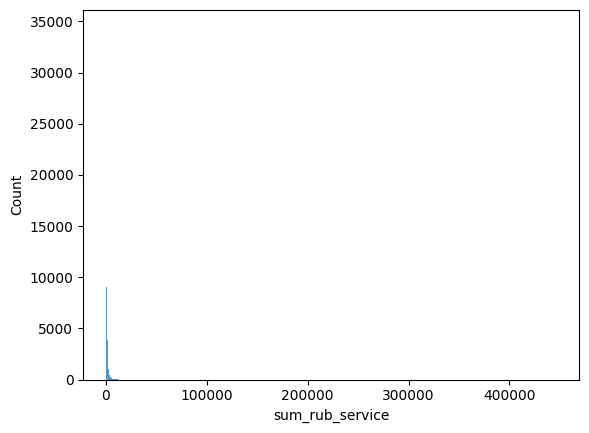

In [23]:
sns.histplot(df.sum_rub_service)

In [24]:
df.sum_rub_service.describe()

count    999992.000000
mean       1126.386955
std        2385.947934
min           0.000000
25%         290.000000
50%         704.000000
75%        1390.000000
max      446687.000000
Name: sum_rub_service, dtype: float64

Тут всё очень грустно, целевая переменная очень перекошенная. Так же по какой-то причине есть бесплатные услуги (как я понимаю это шумы).

In [25]:
df[df.sum_rub_service > 10_000]

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
27,10018218,10018218.4.1,2022-12-11,2022-11-25,2023-01-24,61,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,КТ,NaN,NaN,143991429,26,1,10355
712,100138436,100138436.3.1,2022-05-06,2022-04-28,2022-06-16,50,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,МРТ,NaN,NaN,141119963,10,1,13300
713,100138436,100138436.3.1,2022-05-06,2022-04-28,2022-06-16,50,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,141119963,11,1,10005
843,10044708,10044708.1.1,2022-10-26,2022-10-25,2022-10-26,2,Completed,Не КМ,Очно,Стационар,...,NaN,NaN,NaN,NaN,NaN,NaN,45022505,3,5,16847
1091,100139035,100139035.2.1,2022-06-21,2022-06-21,2022-06-29,9,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,140792334,5,1,10194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999820,142172700,142172700.2.1,2022-03-25,2022-02-22,2022-03-30,37,Completed,Не КМ,Очно,Стационар,...,NaN,NaN,NaN,NaN,NaN,NaN,143729455,40,1,20363
999937,142172707,142172707.3.1,2022-07-28,2022-07-27,2022-08-12,17,Completed,Не КМ,Очно,Стационар,...,NaN,NaN,NaN,NaN,NaN,NaN,5000059,18,1,15932
999947,142172707,142172707.3.1,2022-08-07,2022-07-27,2022-08-12,17,Completed,Не КМ,Очно,Стационар,...,NaN,NaN,NaN,NaN,NaN,NaN,5000059,28,5,11490
999950,142172707,142172707.3.1,2022-08-08,2022-07-27,2022-08-12,17,Completed,Не КМ,Очно,Стационар,...,NaN,NaN,NaN,NaN,NaN,NaN,5000059,31,1,13107


In [26]:
df[df.sum_rub_service == 0]

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
57,100134896,100134896.1.1,2022-08-31,2022-08-31,2022-09-14,15,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,УЗИ,NaN,NaN,42,1,1,0
61,100134896,100134896.1.1,2022-09-14,2022-08-31,2022-09-14,15,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - заб. мат.,NaN,42,8,1,0
63,100134896,100134896.1.1,2022-09-14,2022-08-31,2022-09-14,15,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,NaN,NaN,NaN,Повторный,42,4,1,0
66,100134896,100134896.2.1,2022-10-24,2022-10-13,2022-10-24,12,Completed,Не КМ,Очно,Поликлиника,...,NaN,Психолог,NaN,NaN,NaN,Первичный,42,3,1,0
67,100134896,100134896.2.1,2022-10-13,2022-10-13,2022-10-24,12,Completed,Не КМ,Очно,Поликлиника,...,Терапевт,Терапевт,NaN,NaN,NaN,Повторный,42,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992243,142162673,142162673.1.1,2022-09-29,2022-09-29,2022-09-29,1,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,147598058,1,1,0
993671,142166465,142166465.1.1,2022-03-17,2022-03-17,2022-03-17,1,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,145238262,1,1,0
994872,142166045,142166045.3.1,2022-08-28,2022-08-28,2022-08-29,2,Completed,Не КМ,Очно,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45021569,1,1,0
994875,142166045,142166045.3.1,2022-08-28,2022-08-28,2022-08-29,2,Completed,Не КМ,Очно,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45021569,4,7,0


In [27]:
df.groupby(['session_id', 'service_rownum']).first()

user_id date_service session_start_date   
session_id    service_rownum                                              
1000167.1.1   1                 1000167   2022-01-17         2022-01-17  \
              2                 1000167   2022-01-17         2022-01-17   
              3                 1000167   2022-01-17         2022-01-17   
1000167.2.1   1                 1000167   2022-04-03         2022-04-03   
              2                 1000167   2022-04-14         2022-04-03   
...                                 ...          ...                ...   
142172803.1.1 2               142172803   2022-02-02         2022-01-27   
              3               142172803   2022-02-07         2022-01-27   
142172803.2.1 2               142172803   2022-03-30         2022-03-29   
              3               142172803   2022-04-02         2022-03-29   
              5               142172803   2022-04-15         2022-03-29   

                             session_end_date  session_length session_status   
session_id    service_rownum                                                   
1000167.1.1   1                    2022-01-17               1      Completed  \
              2                    2022-01-17               1      Completed   
              3                    2022-01-17               1      Completed   
1000167.2.1   1                    2022-04-14              12      Completed   
              2                    2022-04-14              12      Completed   
...                                       ...             ...            ...   
142172803.1.1 2                    2022-02-07              12      Completed   
              3                    2022-02-07              12      Completed   
142172803.2.1 2                    2022-05-06              39      Completed   
              3                    2022-05-06              39      Completed   
              5                    2022-05-06              39      Completed   

                             segment channel   subchannel   
session_id    service_rownum                                
1000167.1.1   1                Не КМ    Очно  Поликлиника  \
              2                Не КМ    Очно  Поликлиника   
              3                Не КМ    Очно  Поликлиника   
1000167.2.1   1                Не КМ    Очно  Поликлиника   
              2                Не КМ    Очно  Поликлиника   
...                              ...     ...          ...   
142172803.1.1 2                Не КМ    Очно  Поликлиника   
              3                Не КМ    Очно  Поликлиника   
142172803.2.1 2                Не КМ    Очно  Поликлиника   
              3                Не КМ    Очно  Поликлиника   
              5                Не КМ    Очно  Поликлиника   

                                          service_category   
session_id    service_rownum                                 
1000167.1.1   1                                       None  \
              2                                       None   
              3                                       None   
1000167.2.1   1                                       None   
              2                                       None   
...                                                    ...   
142172803.1.1 2                    Приемы или консультации   
              3                    Приемы или консультации   
142172803.2.1 2               Инструментальная диагностика   
              3               Инструментальная диагностика   
              5               Инструментальная диагностика   

                             doctor_specialization doctor_speciality   
session_id    service_rownum                                           
1000167.1.1   1                               None              None  \
              2                               None              None   
              3                               None              None   
1000167.2.1   1                               None    

#### На взгляд вырисовываются следующие основные проблемы с данными:
- Сильная перекошенность целевой переменной<br>
(Есть как услуги за 0 рублей, так и услуги более чем за 10 тысяч рублей)
-  Большое количество записей, которые не имеют никаких пометок, кроме service category. А так же около 200-от тысяч наблюдений, у которых также нет service category

### Препроцессинг данных

Сначала разберёмся со всеми колонками, где отсутствие данных логично, как я упоминал выше

In [28]:
df[df.service_category.isna()].groupby(['session_id', 'service_rownum']).first()

user_id date_service session_start_date   
session_id    service_rownum                                              
1000167.1.1   1                 1000167   2022-01-17         2022-01-17  \
              2                 1000167   2022-01-17         2022-01-17   
              3                 1000167   2022-01-17         2022-01-17   
1000167.2.1   1                 1000167   2022-04-03         2022-04-03   
              2                 1000167   2022-04-14         2022-04-03   
...                                 ...          ...                ...   
142172786.1.1 7               142172786   2022-04-18         2022-04-14   
              8               142172786   2022-04-18         2022-04-14   
              9               142172786   2022-04-18         2022-04-14   
              10              142172786   2022-04-18         2022-04-14   
              11              142172786   2022-04-18         2022-04-14   

                             session_end_date  session_length session_status   
session_id    service_rownum                                                   
1000167.1.1   1                    2022-01-17               1      Completed  \
              2                    2022-01-17               1      Completed   
              3                    2022-01-17               1      Completed   
1000167.2.1   1                    2022-04-14              12      Completed   
              2                    2022-04-14              12      Completed   
...                                       ...             ...            ...   
142172786.1.1 7                    2022-04-18               5      Completed   
              8                    2022-04-18               5      Completed   
              9                    2022-04-18               5      Completed   
              10                   2022-04-18               5      Completed   
              11                   2022-04-18               5      Completed   

                             segment channel   subchannel service_category   
session_id    service_rownum                                                 
1000167.1.1   1                Не КМ    Очно  Поликлиника             None  \
              2                Не КМ    Очно  Поликлиника             None   
              3                Не КМ    Очно  Поликлиника             None   
1000167.2.1   1                Не КМ    Очно  Поликлиника             None   
              2                Не КМ    Очно  Поликлиника             None   
...                              ...     ...          ...              ...   
142172786.1.1 7                Не КМ    Очно  Поликлиника             None   
              8                Не КМ    Очно  Поликлиника             None   
              9                Не КМ    Очно  Поликлиника             None   
              10               Не КМ    Очно  Поликлиника             None   
              11               Не КМ    Очно  Поликлиника             None   

                             doctor_specialization doctor_speciality   
session_id    service_rownum                                           
1000167.1.1   1                               None              None  \
              2                               None              None   
              3                               None              None   
1000167.2.1   1                               None              None   
              2                               None              None   
...                                            ...               ...   
142172786.1.1 7                               None              None   
              8                               None              None   
              9                               None              None   
              10                              None              None   
              11                              None              None   

                             physiotherapy_type diagnostics_typ

Чтобы заменить по-умному, вместо просто замещения NaN каким-либо константным значением (например, неизвестно), заменим сначала те значения которые мы знаем (например если есть *laboratory_type*, значит *doctor_speciality* должен быть пустым)

In [29]:
check_cols = ['doctor_specialization', 'doctor_speciality', 'physiotherapy_type', 'diagnostics_type']
df[~df.laboratory_type.isna()][check_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 294194 entries, 0 to 999971
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   doctor_specialization  0 non-null      object
 1   doctor_speciality      0 non-null      object
 2   physiotherapy_type     0 non-null      object
 3   diagnostics_type       0 non-null      object
dtypes: object(4)
memory usage: 11.2+ MB


Гипотеза верна - там где есть тип лаборатории остальные колонки пустые (с остальными колонками я провёл такой же эксперимент). Приступим к замене.

In [5]:
columns_to_fill = ['doctor_speciality',  
                   'physiotherapy_type', 
                   'diagnostics_type', 
                   'laboratory_type']

# Чем мы будем заменять
categories = {
    'doctor_speciality': 'Doctor',
    'physiotherapy_type': 'Physiotherapy',
    'diagnostics_type': 'Diagnostics',
    'laboratory_type': 'Laboratory'
}
for col, category in categories.items():
    mask = df[col].notna()
    df.loc[mask, columns_to_fill] = df.loc[mask, columns_to_fill].apply(lambda row: row.fillna(category), axis=1)

Проверяем результаты

In [31]:
check_cols = ['laboratory_type', 'physiotherapy_type', 'diagnostics_type', 'doctor_speciality']
df[~df.doctor_speciality.isna()][check_cols]

,laboratory_type,physiotherapy_type,diagnostics_type,doctor_speciality
0,Лаб. усл. - биохим.,Laboratory,Laboratory,Laboratory
1,Лаб. усл. - биохим.,Laboratory,Laboratory,Laboratory
2,Лаб. усл. - биохим.,Laboratory,Laboratory,Laboratory
3,Лаб. усл. - биохим.,Laboratory,Laboratory,Laboratory
4,Лаб. усл. - биохим.,Laboratory,Laboratory,Laboratory
...,...,...,...,...
999995,Doctor,Doctor,Doctor,Терапевт
999996,Doctor,Doctor,Doctor,Терапевт
999997,Diagnostics,Diagnostics,Эндоскопия,Diagnostics
999998,Diagnostics,Diagnostics,МРТ,Diagnostics


<Axes: >

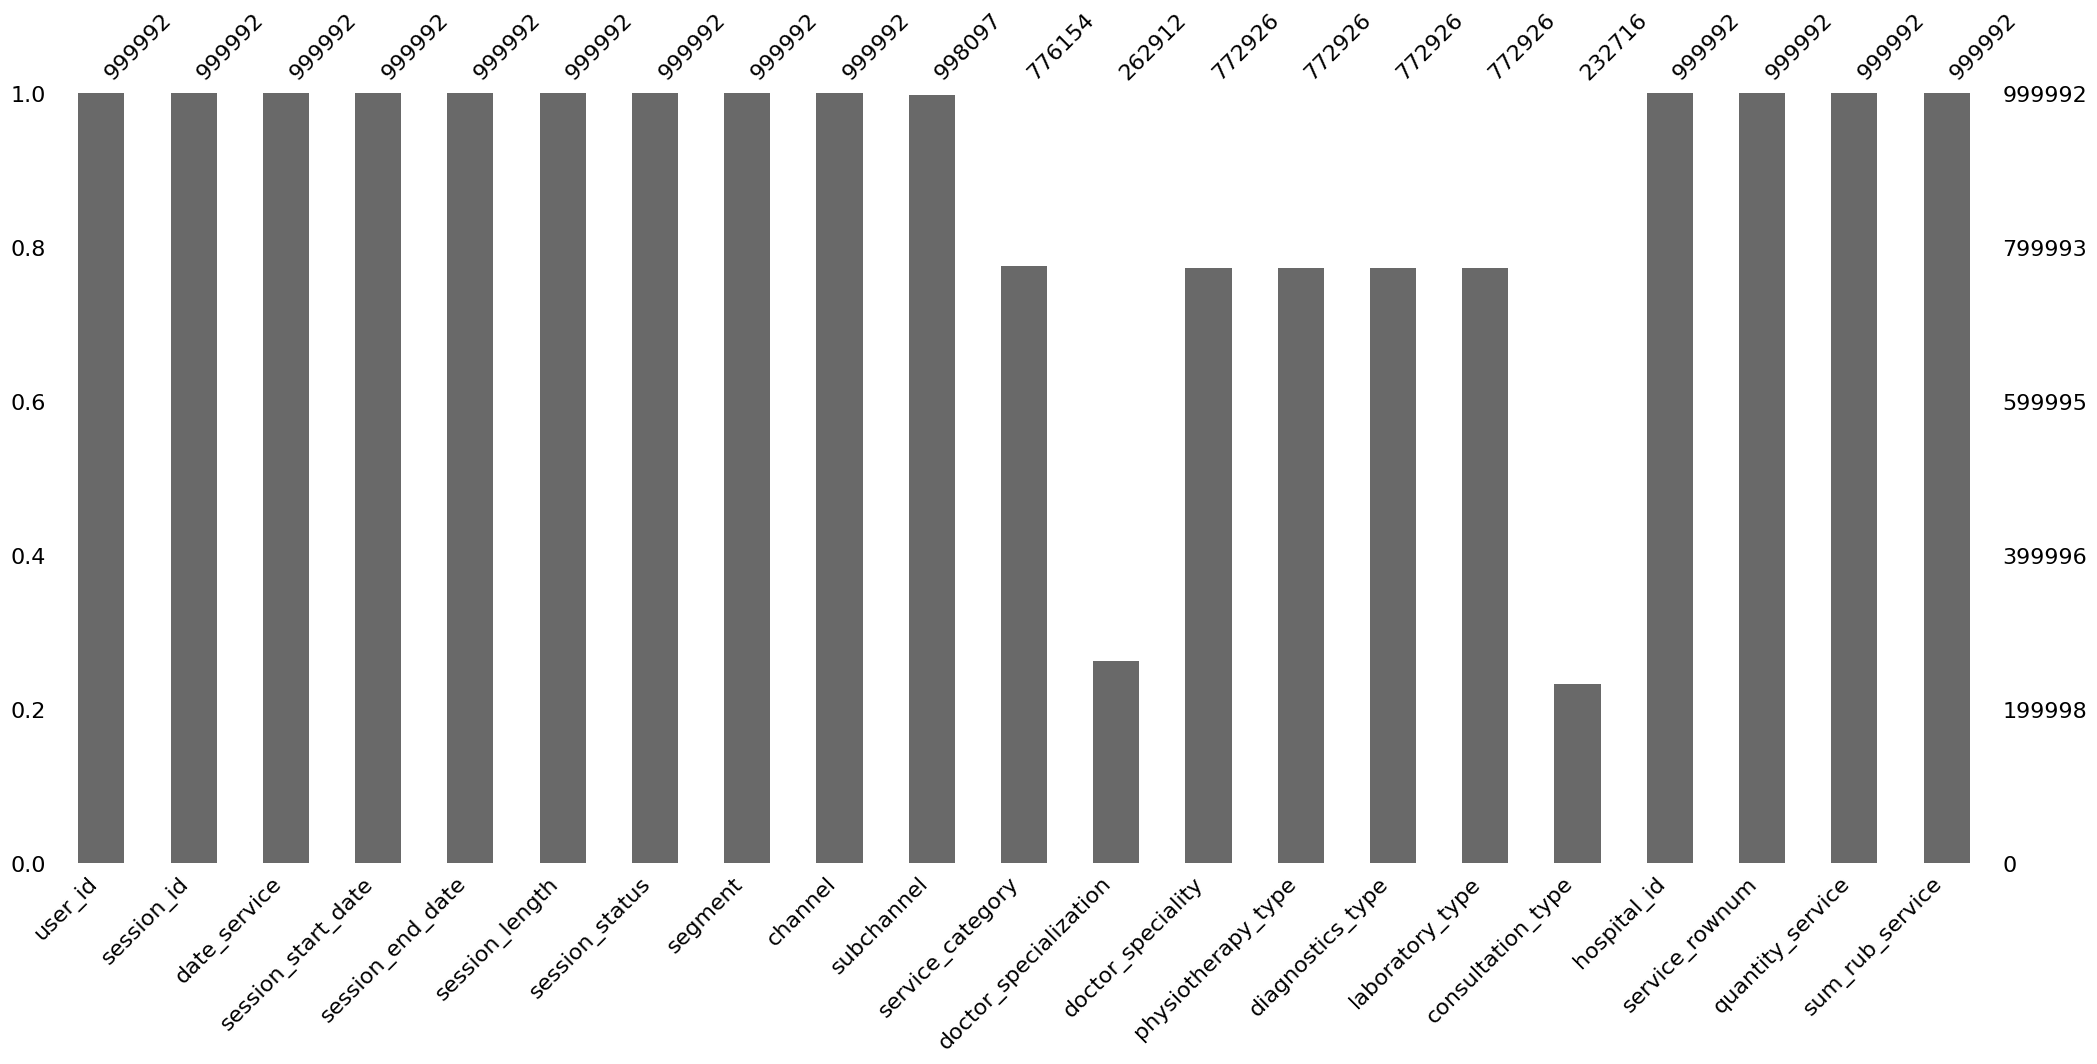

In [32]:
msgn.bar(df)

Теперь интересующие нас колонки выравнялись с *service_category*. Остаются только две колонки - *doctor_specialization* и *consultation_type*, их я оставил специально. Если вторую ещё можно заменить основываясь, на других колонках, то в первую нужно вписывать два разных значения. Например, если у нас есть *doctor_speciality*, то например прямо оттуда, а если его нет (было что-то другое), то также как в случае и с остальными, Laboratory/Diagnostics/etc.

In [33]:
df[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna()) 
       & (df.doctor_specialization.isna())].doctor_specialization.info()

<class 'pandas.core.series.Series'>
Index: 13233 entries, 65 to 999637
Series name: doctor_specialization
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 206.8+ KB


In [34]:
df.loc[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna()) 
       & (df.doctor_specialization.isna()), 'doctor_specialization']

65        NaN
66        NaN
69        NaN
70        NaN
91        NaN
         ... 
999467    NaN
999492    NaN
999493    NaN
999564    NaN
999637    NaN
Name: doctor_specialization, Length: 13233, dtype: object

In [6]:
df.loc[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna()) 
       & (df.doctor_specialization.isna()), 'doctor_specialization'] = df[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna()) 
       & (df.doctor_specialization.isna())].doctor_speciality

In [36]:
df.loc[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna()) 
       & (df.doctor_specialization.isna()), 'doctor_specialization']

Series([], Name: doctor_specialization, dtype: object)

Выравняем по остальным колонкам

In [7]:
df.loc[(df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy']))
       & (df.doctor_specialization.isna()), 'doctor_specialization'] = df[df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])].doctor_speciality

Осталось справиться с последней колонкой - *consultation_type*. Заменим там где есть laboratory, diagnostics, etc. значения на "No Consultation". Перед этим проверим - везде ли у нас пропуски по консультациям, где в принципе указан врач.

In [38]:
df[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna()) 
       & (df.consultation_type.isna())].consultation_type.info()

<class 'pandas.core.series.Series'>
Index: 47894 entries, 52 to 999982
Series name: consultation_type
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 748.3+ KB


Таких пропусков нет, всё окей, заменяем

In [8]:
df.loc[(df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (df.consultation_type.isna()), 'consultation_type'] = 'No Consultation'

<Axes: >

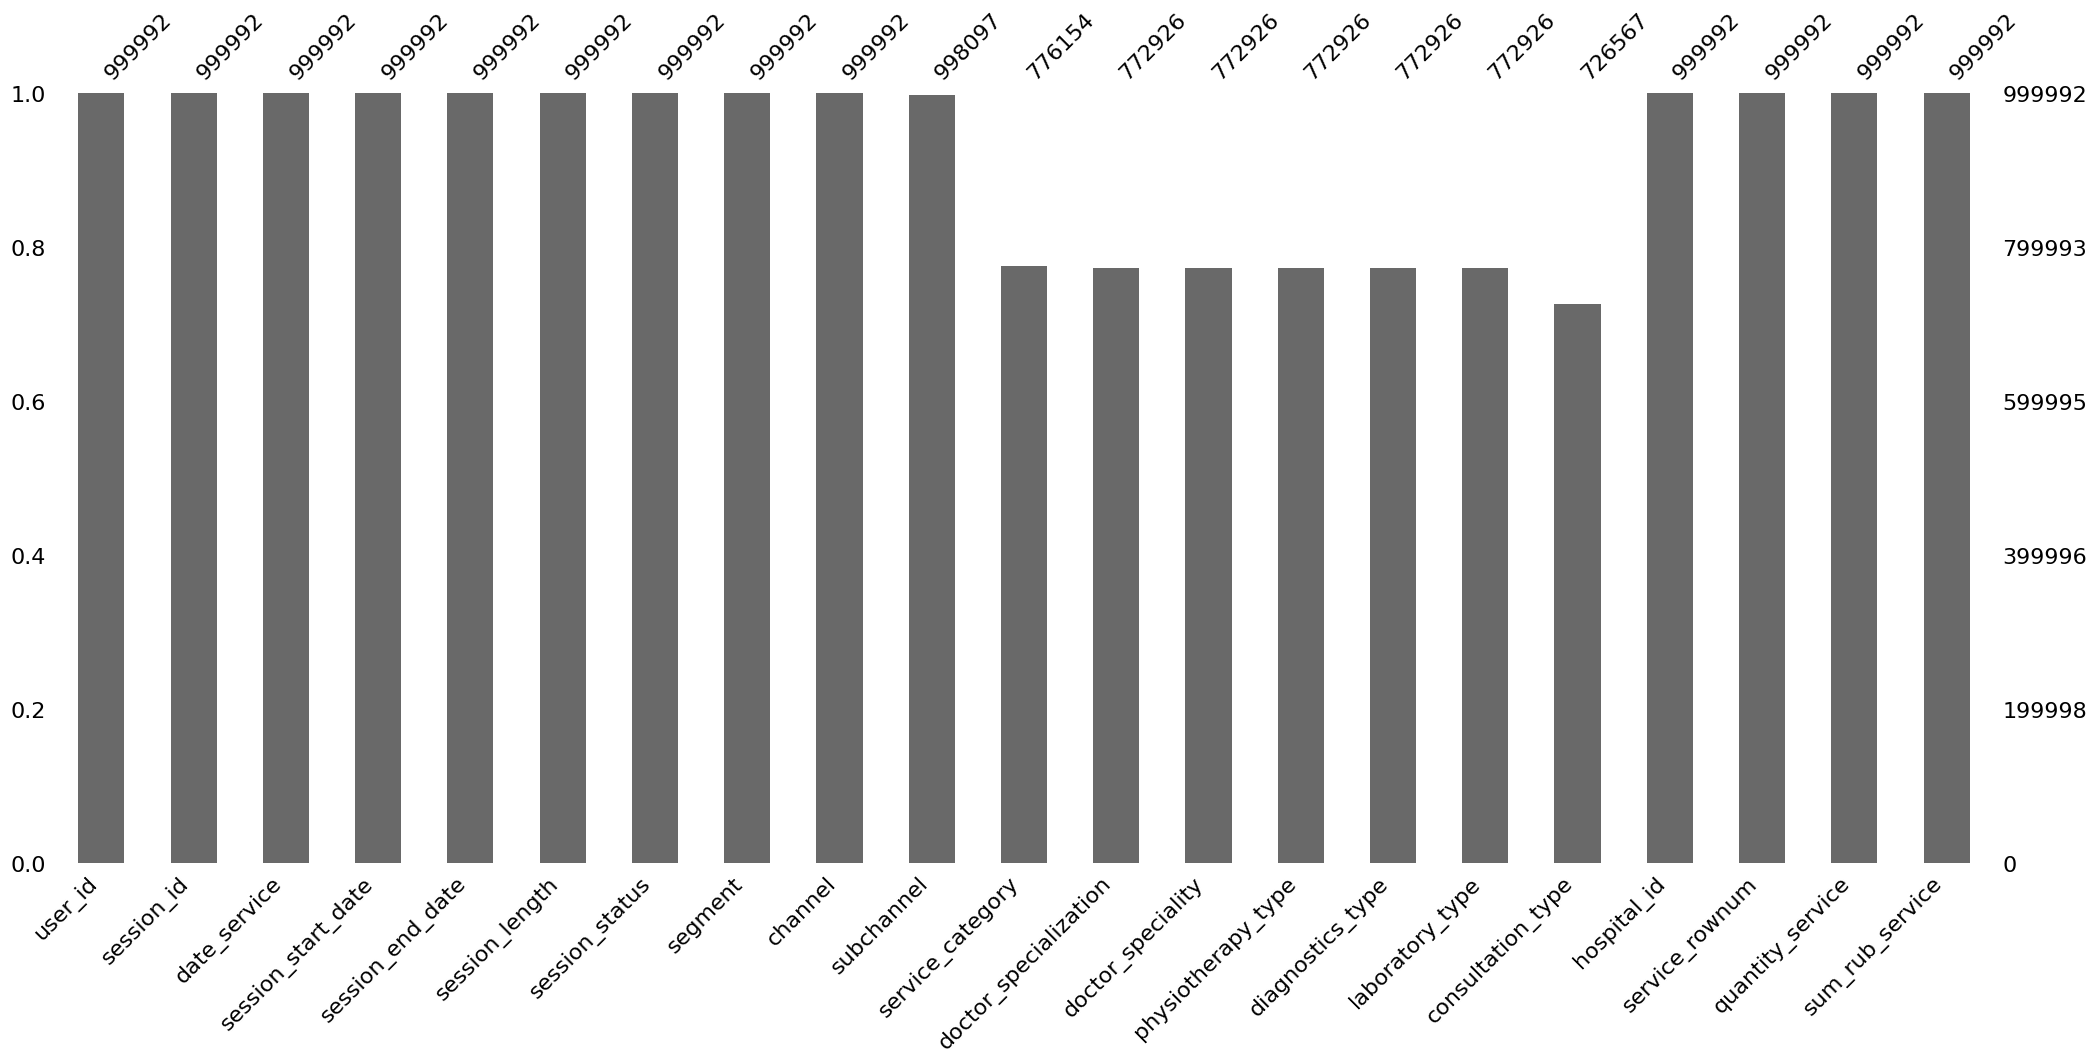

In [40]:
msgn.bar(df)

Часть *consultation_type* осталась незаполненной, в тех местах где был указан какой-либо *doctor_speciality*. Там есть смысл вписать Consultation uknown, чтобы отличалось от общих NaN.

In [9]:
df.loc[(~df.doctor_speciality.isin(['Laboratory', 'Diagnostics', 'Physiotherapy'])) 
       & (~df.doctor_speciality.isna())
       & (df.consultation_type.isna()), 'consultation_type'] = 'Consultation Unknown'

Остальные же данные заполним просто 'Unknown'.

In [17]:
fill_col = ['service_category', 'doctor_specialization', 'doctor_speciality',
            'physiotherapy_type', 'diagnostics_type', 'laboratory_type', 'consultation_type']
df[fill_col] = df[fill_col].fillna('Unknown')

<Axes: >

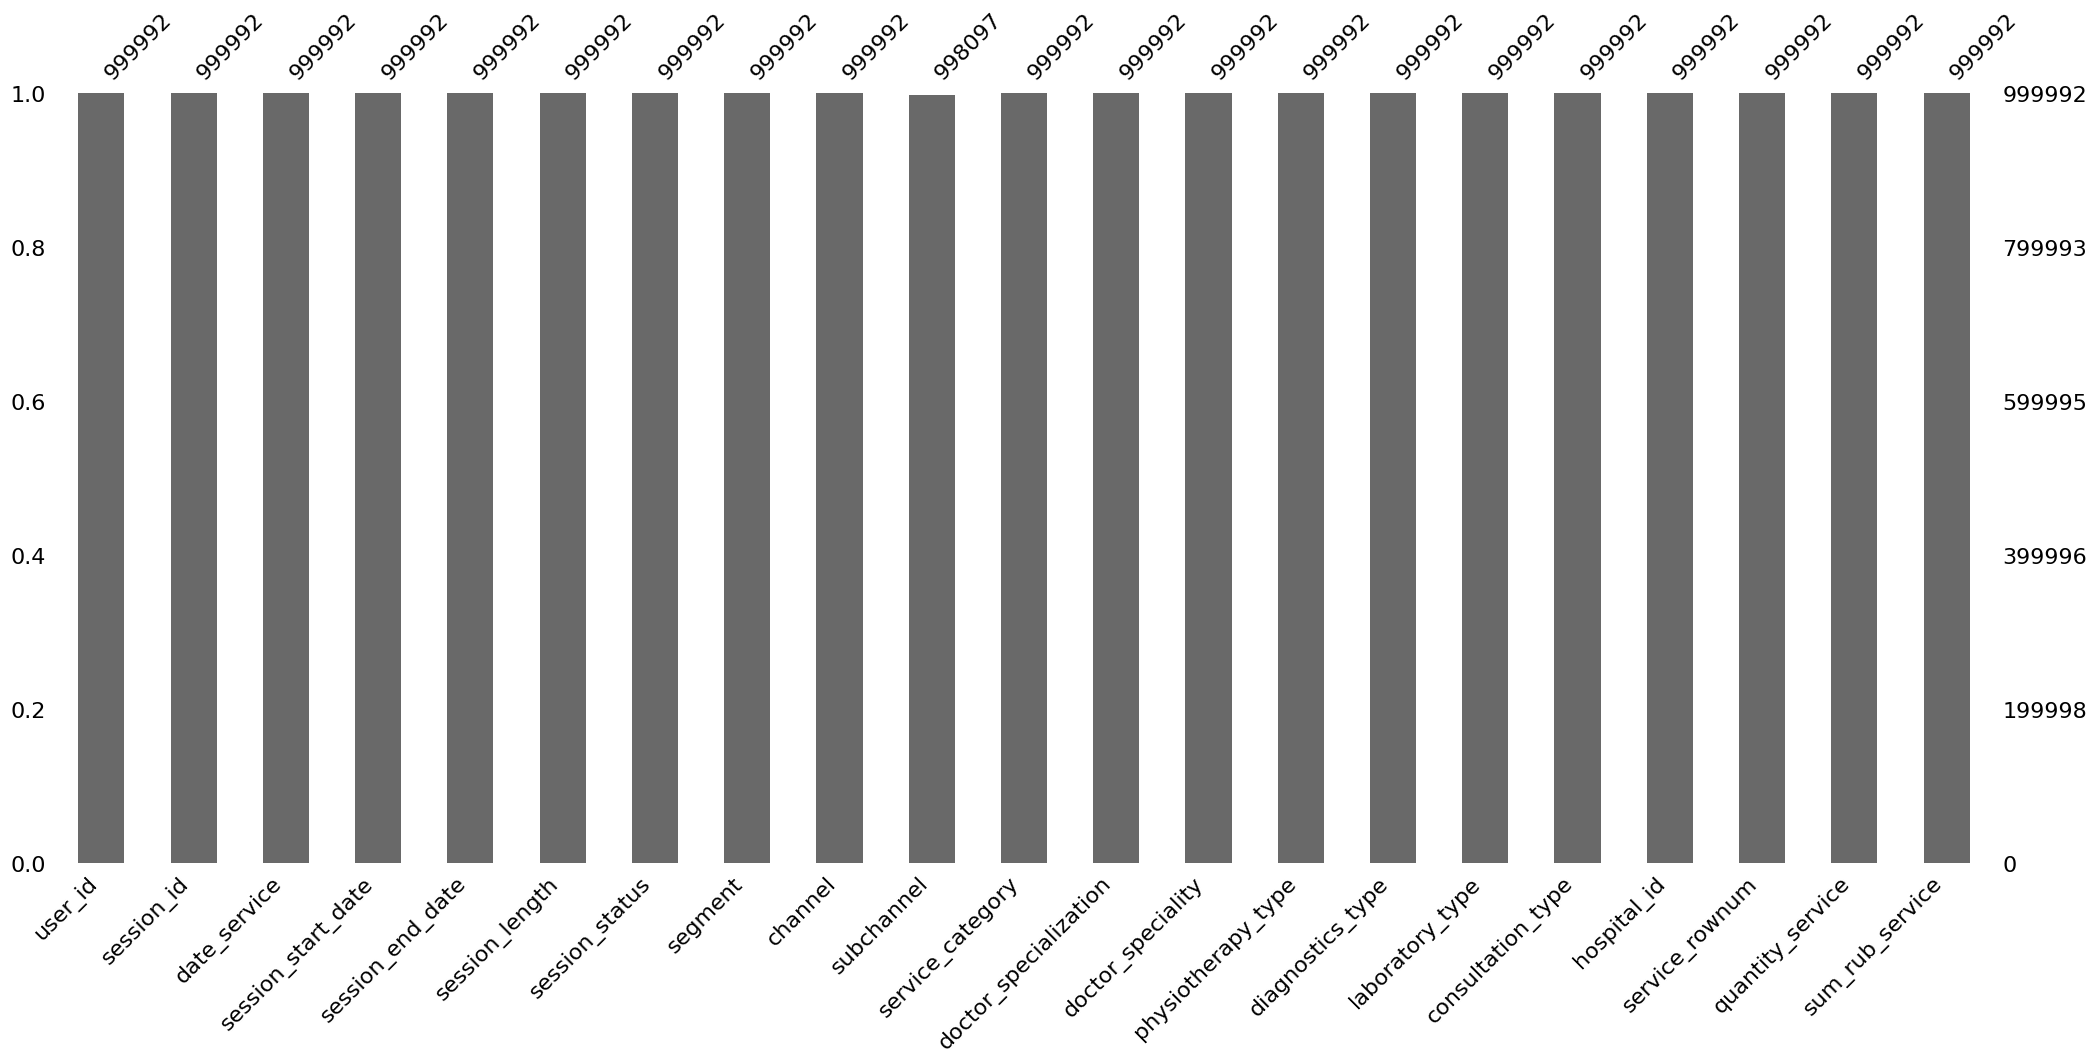

In [18]:
msgn.bar(df)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999992 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                999992 non-null  int64         
 1   session_id             999992 non-null  object        
 2   date_service           999992 non-null  datetime64[ns]
 3   session_start_date     999992 non-null  datetime64[ns]
 4   session_end_date       999992 non-null  datetime64[ns]
 5   session_length         999992 non-null  int64         
 6   session_status         999992 non-null  object        
 7   segment                999992 non-null  object        
 8   channel                999992 non-null  object        
 9   subchannel             998097 non-null  object        
 10  service_category       999992 non-null  object        
 11  doctor_specialization  999992 non-null  object        
 12  doctor_speciality      999992 non-null  object   

Всё, с NaN справились<br>
Закодируем текстовые признаки, чтобы с ними можно было работать

In [19]:
encode_cols = ['session_status', 'segment', 'channel', 'subchannel',
              'service_category', 'doctor_specialization', 'doctor_speciality',
              'physiotherapy_type', 'diagnostics_type', 'laboratory_type', 'consultation_type']
encoders = []
for col in encode_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders.append(enc)

Т.к. *session_id* это по-сути ключевое поле, а остальные дата - исключаем их из корелляции

Не смотря на то что корреляция не всегда показывает прямую зависимость одного от другого, можно заметить что ключевая колонка *sum_rub_service* имеет какую-то зависимость от *laboratory_type*, *service_category* и *subchannel*.<br>
Однако нельзя исключать того, что зависимость мнимая, просто по той причине, что числа в этих колонках это закодированные категориальные признаки.

<Axes: >

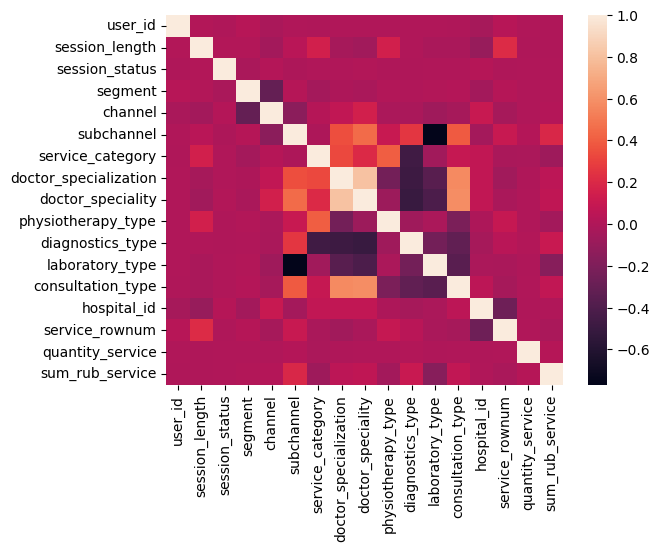

In [20]:
non_corr = ['session_id', 'date_service', 'session_start_date', 'session_end_date']
date_cols = ['date_service', 'session_start_date', 'session_end_date']
sns.heatmap(df.drop(non_corr, axis=1).corr())

Ещё один способ узнать влияние на целевую переменную - построить дерево решений. Т.к. одно дерево склонно к переобучению и оценить насколько реально будет влиять тот или иной признак в этом случае будет затруднительно, имеет смысл построить случайный лес и взять важность признаков оттуда.

In [47]:
X, y = df.drop([*date_cols, 'sum_rub_service', 'session_id'], axis=1), df.sum_rub_service
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
forest = RandomForestRegressor(random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
preds = forest.predict(x_test)
print('R2:', r2_score(y_test, preds))
print('MAE:', mean_absolute_error(y_test, preds))

R2: 0.2529994241501342
MAE: 510.120774884025


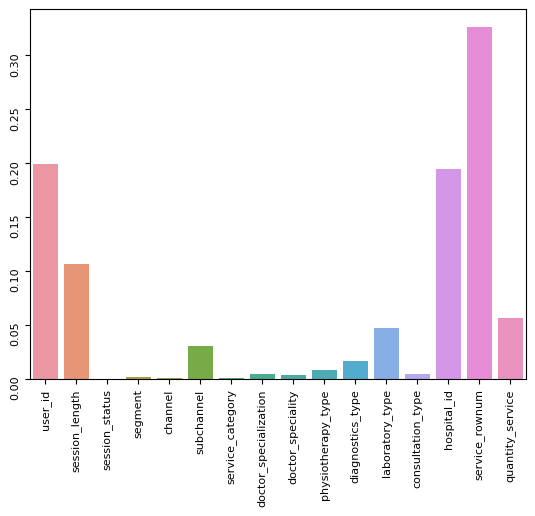

In [49]:
b = sns.barplot(pd.DataFrame([forest.feature_importances_], columns=X_train.columns))
b.tick_params(labelsize=8, rotation=90)

Интересно, что модель считает *hospital_id*, *user_id*, *service_rownum* и *session_length* важными признаками, которые влияют на стоимость. Что если убрать какие-то из них? (Не думаю например, что *service_rownum* должен иметь такой большой вес)

In [18]:
X, y = df.drop([*date_cols, 'sum_rub_service', 'session_id', 'service_rownum'], axis=1), df.sum_rub_service
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestRegressor(random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
preds = forest.predict(x_test)
print('R2:', r2_score(y_test, preds))
print('MAE:', mean_absolute_error(y_test, preds))

R2: 0.2529994241501342
MAE: 510.120774884025


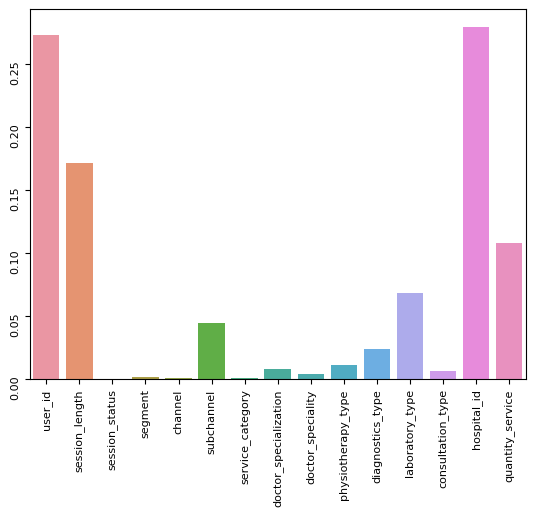

In [51]:
b = sns.barplot(pd.DataFrame([forest.feature_importances_], columns=X_train.columns))
b.tick_params(labelsize=8, rotation=90)

Интересно получилось, метрики никак не изменились, а модель стала обращать внимание больше на *userd_id* и *hospital_id*

Можно попробовать разобраться с целевой переменной, чтобы уменьшить её перекошенность. Однако в таком случае стоит помнить, что метрики тоже поменяются, если не преобразовывать целевую переменную обратно.

In [53]:
df.sum_rub_service.skew()

44.01458602177811

<Axes: xlabel='sum_rub_service', ylabel='Count'>

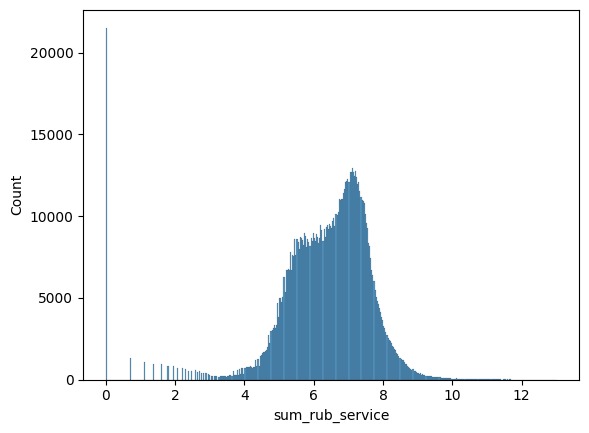

In [54]:
sns.histplot(np.log1p(df.sum_rub_service))

In [55]:
np.log1p(df.sum_rub_service).skew()

-1.8963263423953665

Однако проблему нулей это не решает, с ними нужно как-то разбираться. Попробуем сначала, просто оставляя нули.

R2: 0.24374963131191185
MAE: 466.79144491893004


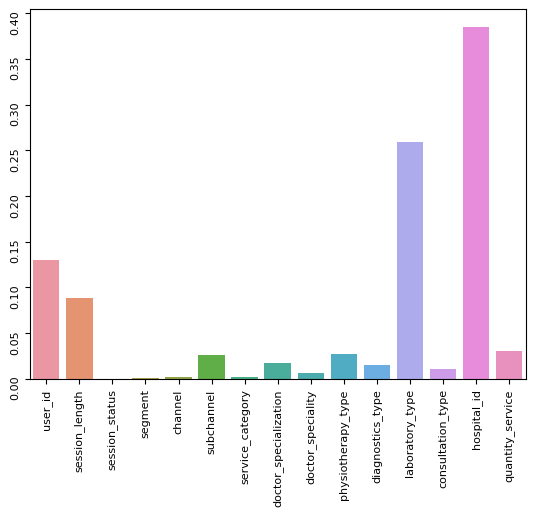

In [16]:
df_no_skew = df.copy()
df_no_skew.sum_rub_service = np.log1p(df.sum_rub_service)
X, y = df_no_skew.drop(
    [*date_cols, 'sum_rub_service', 'session_id', 'service_rownum'], axis=1), df_no_skew.sum_rub_service
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestRegressor(random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
preds = forest.predict(x_test)
print('R2:', r2_score(np.expm1(y_test), np.expm1(preds)))
print("MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(preds)))

b = sns.barplot(pd.DataFrame([forest.feature_importances_], columns=X_train.columns))
b.tick_params(labelsize=8, rotation=90)

Не особо помогло, не смотря на то что MAE в целом ненамного, но уменьшился. Значит перекошенность целевой переменной в этом конкретном случае не особо влияет на модель. Теперь можно попробовать убрать нули, т.к. они тоже вносят шумы в данные.

R2: 0.25016091736732005
MAE: 451.7760026253099


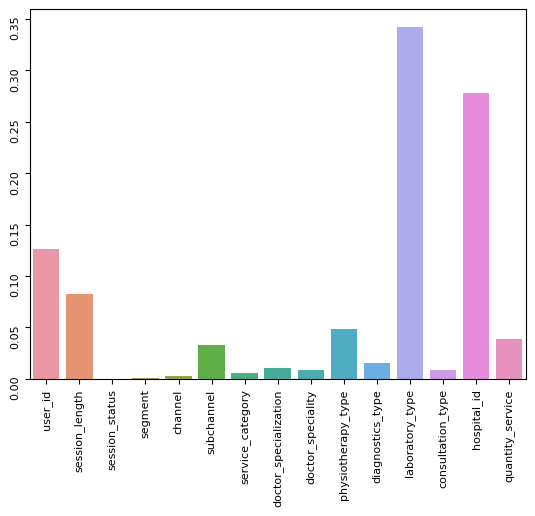

In [17]:
df_no_skew = df[df.sum_rub_service > 0].copy()
df_no_skew.sum_rub_service = np.log1p(df.sum_rub_service)
X, y = df_no_skew.drop(
    [*date_cols, 'sum_rub_service', 'session_id', 'service_rownum'], axis=1), df_no_skew.sum_rub_service
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest = RandomForestRegressor(random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
preds = forest.predict(x_test)
print('R2:', r2_score(np.expm1(y_test), np.expm1(preds)))
print("MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(preds)))

b = sns.barplot(pd.DataFrame([forest.feature_importances_], columns=X_train.columns))
b.tick_params(labelsize=8, rotation=90)

Как и ожидалось, MAE вновь уменьшился но также ненамного. Однако по этим промежуточным результатам уже можно сделать некоторые выводы.

Делая вывод, наиболее важные признаки которые влияют на стоимость отдельной услуги (т.к. тут предикт в разрезе одной услуги) это:
- *user_id*<br>
Почему? Скорее всего есть какие-то пациенты которые тратят в среднем больше остальных
- *session_length*<br>
Логично, что чем длиннее сессия, тем она дороже. Однако, видимо что и чем длиннее сессия, тем выше шанс что там будут дорогие услуги
- *laboratory_type*<br>
Есть какие-то лабораторные услуги которые дороже остальных
- *hospital_id*<br>
Скорее всего, есть какие-то больницы, в а) более дорогие услуги и/или б) более сложное оборудование и более сложные (и как следствие дорогие) услуги

Конкретно в этой задаче мы должны предсказывать стоимость не отдельной услуги, а суммарную стоимость сессии, поэтому более уместен подход с представлением данных в формате time-series. Если посмотреть на количество оказанных услуг по сессиям, можно сделать вывод, что у большинства сессий количество оказанных услуг колеблется в районе 5 штук и 75% охват мы имеем при 12 услугах.

In [57]:
df.groupby('session_id').size().describe()

count    97168.000000
mean        10.291372
std         18.278608
min          1.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       1566.000000
dtype: float64

### Прогнозирование стоимости сессии

Для упрощения работы с данными, будем использовать паддинг.<br>
Для паддинга, сделаем максимальную длинну сессии в 14 услуг, всё что больше будет ограничено 14-ю услугами, всё что ниже будет заполнено нулями до 14-и.<br>

Также, так как нам нужно предсказывать будущую стоимость, будем ограничивать наши данные половиной услуг. То есть если в сессии было 12 услуг, то на вход мы будем подавать 6 услуг + 8 пустых записей.<br>
Также нам нужно сделать все те преобразования, что мы делали ранее (лог-трансформация целевой переменной, выкидывание нулей) плюс нормализацию.

Для экспериментов были выбраны два подхода, обучение RNN на данных в формате time-series и обучение RandomForest на данных, в формате "лагов", где фичи из 14-и временных шагов объединены в одно наблюдение, с целевой переменной в виде общей суммы сессии. Формат данных одинаков и для RNN и для RandomForest, в первом случае временные данные раскиданы в форме *(batch_size, timestep, features)*, во втором случае каждая сессия выглядит как запись в таблице с 200 колонками в формате *sum_rub_service_lag0*, *sum_rub_service_lag1* etc., для каждого признака (не константного).

Оба этих подхода позволяют упростить задачу, т.к. в случае решения её именно с использованием классических time-series алгоритмов, возможно предсказание либо 
- А) Стоимости следующей сессии, базируясь на стоимости предыдущей (такое тоже возможно, но это не наша задача)
- Б) Стоимости следующей услуги в сессии, базируясь на предыдущих услугах. Здесь есть оговорка, мы не можем предсказывать стоимость сессии, т.к. мы не знаем количество услуг в сессии. Можно либо просто брать медиану (предсказывать 5 услуг) либо обучить ещё одну модель на задачу time-series регрессии, предсказывать будущее число услуг которые будут оказаны. Минус такого подхода сразу в том, что мы комбинируем две независимые модели, а значит суммарные метрики у нас будут гораздо ниже, нежели если мы будем использовать одну модель.

Поэтому был выбран наиболее простой путь - попробовать одну классическую модель и одну модель DL.<br>
У обеих моделей задача была одна - предсказывать стоимость сессии (суммарную стоимость всех услуг в ней).

### RandomForestRegressor

In [43]:
def reshape_group(group: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для урезания услуг по группам, их паддингу (если нужно)
    и созданию лагов по временным шагам
    """
    horizon = 14
    group = group.sort_values('service_rownum')
    
    # Делим напополам
    half_length = min(len(group) // 2, horizon)
    group_half = group.head(half_length)
    
    # Паддинг, если нужен
    pad_length = horizon - len(group_half)
    if pad_length > 0:
        pad_data = {col: [0] * pad_length for col in group.columns}
        pad_data['session_id'] = [group_half['session_id'].iloc[0]] * pad_length
        pad_data['session_length'] = [group_half['session_length'].iloc[0]] * pad_length
        pad_df = pd.DataFrame(pad_data)
        group_half = pd.concat([group_half, pad_df], ignore_index=True)

        
    drop_cols = ['session_id', 'session_length', 'user_id', *date_cols, 'session_status']
    # Выкидываем временные колонки и те, что не меняются со временем
    features_to_reshape = group_half.drop(columns=drop_cols)

    # Решейпим фичи для лагов
    reshaped_data = features_to_reshape.values.T.flatten()
    reshaped_index = [f'{col}_lag{lag}' for col in features_to_reshape.columns for lag in range(horizon)]
    
    # Создаём сириес с правильным индексом и нашими фичами
    reshaped_data = pd.Series(reshaped_data, index=reshaped_index)
    reshaped_data['session_id'] = group_half['session_id'].iloc[0]
    reshaped_data['session_length'] = group_half['session_length'].iloc[0]
    reshaped_data['user_id'] = group_half['user_id'].iloc[0]
    reshaped_data['full_sum'] = np.log1p(np.expm1(group.sum_rub_service).sum())
    
    return reshaped_data


In [44]:
# Это чтобы к нам не попали сессии длиной в 1 услугу
df_filtered = df.groupby('session_id').filter(lambda x: len(x) > 1)
df_filtered.sum_rub_service = np.log1p(df_filtered.sum_rub_service)

In [45]:
groups = [group for _, group in df_filtered.groupby('session_id')]

# Параллелизация, т.к. иначе считается долго
reshaped_groups = Parallel(n_jobs=-1)(delayed(reshape_group)(group) for group in groups)
df_reshaped = pd.DataFrame(reshaped_groups).reset_index(drop=True)

In [47]:
df_reshaped

,segment_lag0,segment_lag1,segment_lag2,segment_lag3,segment_lag4,segment_lag5,segment_lag6,segment_lag7,segment_lag8,segment_lag9,...,sum_rub_service_lag8,sum_rub_service_lag9,sum_rub_service_lag10,sum_rub_service_lag11,sum_rub_service_lag12,sum_rub_service_lag13,session_id,session_length,user_id,full_sum
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1000167.1.1,1,1000167,8.681351
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1000167.2.1,12,1000167,8.875287
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1000219.3.1,7,1000219,8.000014
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1000219.4.1,9,1000219,8.339979
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1000219.5.1,9,1000219,8.918784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78107,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.962845,5.407172,5.455321,5.147494,8.849084,6.77308,142172707.3.1,17,142172707,12.036440
78108,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,5.921578,6.102559,7.337588,6.161207,0.000000,0.00000,142172784.1.1,21,142172784,9.797682
78109,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,142172786.1.1,5,142172786,10.295935
78110,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,142172803.1.1,12,142172803,7.293018


In [19]:
# Откидываем шумы
df_reshaped = df_reshaped[df_reshaped.sum_rub_service_lag0 > 0]

In [26]:
forest_num_services = RandomForestRegressor(n_jobs=-1, random_state=42)

X, y = df_reshaped.drop(
    ['session_length', 'session_id', 'full_sum'], axis=1), df_reshaped.full_sum
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest_num_services.fit(X_train, y_train)
preds = forest_num_services.predict(x_test)
print('R2:', r2_score(np.expm1(y_test), np.expm1(preds)))
print("MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(preds)))

R2: 0.46875103288147546
MAE: 4335.229423986098


Метрики достаточно неплохие для такого простого подхода, если например использовать не RandomForest, а какой-то бустинг (CatBoost, XGBoost, etc.) то скорее всего можно добиться гораздо более высоких результатов. Проверим модель на CV.

In [46]:
forest_num_services = RandomForestRegressor(n_jobs=-1, random_state=42)

X, y = df_reshaped.drop(
    ['session_length', 'session_id', 'full_sum'], axis=1), df_reshaped.full_sum
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

mae = []
r2 = []

fold = KFold()
for train_ind, test_ind in fold.split(X, y):
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_test, y_test = X.iloc[test_ind], y.iloc[test_ind]
    
    forest_num_services = RandomForestRegressor(n_jobs=-1, random_state=42)
    forest_num_services.fit(X_train, y_train)
    preds = forest_num_services.predict(X_test)
    
    r2.append(r2_score(np.expm1(y_test), np.expm1(preds)))
    mae.append(mean_absolute_error(np.expm1(y_test), np.expm1(preds)))
    
print('R2:', np.mean(r2))
print("R2 max:", np.max(r2))
print("MAE:", np.mean(mae))
print("MAE min:", np.min(mae))

R2: 0.5372582831036663
R2 max: 0.6434103369889932
MAE: 4430.989229578599
MAE min: 3984.4344944441937


На CV результаты даже лучше.

In [23]:
forest_num_services = RandomForestRegressor(n_jobs=-1, random_state=42)

X, y = df_reshaped.drop(
    ['session_length', 'session_id', 'full_sum'], axis=1), df_reshaped.full_sum
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

forest_num_services.fit(X_train, y_train)
preds = forest_num_services.predict(x_test)
print('R2:', r2_score(np.expm1(y_test), np.expm1(preds)))
print("MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(preds)))

R2: 0.7007355860749399
MAE: 3722.782718427415


Любопытно, что повышая лаг, с 14 до 25, и выше, метрики начинают очень быстро расти. Вероятнее всего это связано с тем, что многие данные с "правой" стороны распределения (где высокие цены и куда уходит скос) имеют большее количество услуг в сессии и увеличение лага облегчает их прогнозирование.

#### Анализ модели

In [43]:
importance = pd.DataFrame([forest_num_services.feature_importances_], columns=X_train.columns)
importance_transposed = importance.transpose()

# Сортируем по важности
sorted_importance = importance_transposed.sort_values(by=0, ascending=False)
sorted_importance.head(30)

,0
sum_rub_service_lag0,0.265062
hospital_id_lag4,0.128117
service_rownum_lag4,0.127809
hospital_id_lag3,0.100501
sum_rub_service_lag1,0.071222
service_rownum_lag3,0.043813
sum_rub_service_lag2,0.033408
hospital_id_lag0,0.023706
user_id,0.016814
hospital_id_lag11,0.014606


Топ-30 важных фич, это:
- `user_id` Кто-то тратит больше остальных
- `sum_rub_service` Напрямую влияет на полную стоимость сессии
- `quantity_service` Опять же, чем больше раз была проведена услуга, тем больше шанс что вся сессия будет дороже
- `service_rownum` Если у нас уже было проведено 10 услуг без паддинга, значит скорее всего общая стоимость будет выше
- `hospital_id` В некоторых больницах либо есть больше дорогих услуг, либо в целом услуги более дорогие
- `doctor_specialization` Здесь уже зависимость интереснее. Могу объяснить либо тем, что есть некоторые более дорогие врачи, либо посещение каких-либо врачей в будущем влечёт за собой большие траты на услуги

Можно также взять медиану по всем лагам и посмотреть на получившийся список.

In [44]:
feature_importance_dict = {}

for col in importance.columns:
    feature_name = col.split('_')[0]  # Без "lag" приписки
    if feature_name not in feature_importance_dict:
        feature_importance_dict[feature_name] = []
    feature_importance_dict[feature_name].append(importance[col].values[0])

# Считаем медиану
median_importance_per_feature = {feature: pd.Series(values).median() for feature, values in feature_importance_dict.items()}

# Сортируем по убыванию
sorted_median_importance = sorted(median_importance_per_feature.items(), key=lambda x: x[1], reverse=True)

In [47]:
pd.DataFrame().from_dict(sorted_median_importance)

,0,1
0,user,0.016814
1,sum,0.006289
2,hospital,0.001710
3,quantity,0.000295
4,laboratory,0.000289
5,subchannel,0.000179
6,diagnostics,0.000146
7,service,0.000123
8,doctor,0.000103
9,physiotherapy,0.000100


Здесь, естественно user выше всего (у него нет лагов), в то время как ниже мы видим ещё новые фичи с высокой важностью (если взять топ-5):
- `laboratory` Скорее всего какие-то лабораторные услуги дороже остальных, либо же после каких-то анализов сессии становятся дороже
- `subchannel` Там хранится субканал оказания услуги, например в случае с посещением стационара услуги логично будут дороже

### RNN

Переходим к следующему методу - предсказанию с помощью RNN. Для начала нам нужен класс Dataset'а через который мы будем обучать модель. Для простоты обучения я использую pytorch-lightning.

In [21]:
class TimeSeriesDataset(Dataset):
    """
    Класс для преобразования данных в time-series формат
    """
    
    def __init__(self, dataframe: pd.DataFrame, 
                 target_col: str, group_col: str, sort_col: str, 
                 n_jobs=-1, padding=True, drop_target=False, max_length=14) -> None:
        
        self.data = []
        self.target_col = target_col
        self.group_col = group_col
        self.sort_col = sort_col
        self.padding = padding
        self.drop_target = drop_target
        self.max_length = max_length
        
        # Т.к. данных у нас много, раскидаем по процессам, 
        # чтобы быстрее обрабатывалось
        results = Parallel(n_jobs=n_jobs)(
            delayed(self.process_group)(group)
            for _, group in dataframe.groupby('session_id')
            if len(group) > 1
        )

        self.data = results

    def process_group(self, group) -> None:
        # Сортируем, чтобы точно будущее не "протекло"
        group = group.sort_values(by=self.sort_col)
        
        # Делим нацело напополам, дропаем колонки
        half_group = group.head(len(group) // 2)
        if self.drop_target:
            half_group = half_group.drop([self.target_col, self.group_col], axis=1)
        else:
            half_group = half_group.drop([self.group_col], axis=1)
        
        # Добавляем паддинг, просто для удобства
        if self.padding:
            half_group = half_group.head(self.max_length)
            padded_group_values = np.zeros((self.max_length, half_group.shape[1]))
            padded_group_values[:len(half_group)] = half_group.values
        # Без паддинга обучать не пробовал
        else:
            padded_group_values = half_group

        # Считаем сумму для таргета
        y = np.log1p(np.expm1(group[self.target_col]).sum())

        # В тензоры
        x_tensor = torch.tensor(padded_group_values, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        return x_tensor, y_tensor

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        return self.data[idx]


In [22]:
# Соответственно как в случае и с деревьями убираем перекос и выкидываем outlier'ы
df_no_skew = df[df.sum_rub_service > 0].copy().drop(columns=date_cols)
df_no_skew.sum_rub_service = np.log1p(df.sum_rub_service)

# Без скейлинга обучение будет нестабильным, поэтому немаловажный шаг. 
columns_to_scale = df_no_skew.columns.difference(['sum_rub_service', 'session_id', 'service_rownum'])
scaler = StandardScaler()
df_no_skew[columns_to_scale] = scaler.fit_transform(df_no_skew[columns_to_scale])
time_data = TimeSeriesDataset(df_no_skew.drop(columns=['session_length', 'session_status']), 
                              'sum_rub_service', 
                              'session_id', 
                              'service_rownum', drop_target=False)

In [26]:
# Делим на 80% train и 20% тест, для повторяемости результата используем manual_seed
train_size = int(0.8 * len(time_data))
test_size = len(time_data) - train_size
train_dataset, test_dataset = random_split(time_data, [train_size, test_size], torch.Generator().manual_seed(42))

#### Разработка RNN-модели для анализа time-series

В качестве архитектуры была выбрана простая RNN сеть, состоящая из `LSTM`+`GRU`. По-моему опыту, комбинация этих двух слоёв чаще всего даёт лучший результат, чем `LSTM`+`LSTM` или `GRU`+`GRU`. Параметры также подобраны эмпирически - полноценным файн-тюнингом я не занимался. Т.к. весь шум связанный с нулями мы удалили, можно пользоваться `mse_loss`, на нём также выходит более высокий скор

В теории можно было бы сделать ещё хитрее - добавить модели вторую голову, которая также регрессией предсказывала бы количество услуг, и затем стоимость считать как `mean_(голова с ценой) * mean(голова с количеством)`. Так как в таком случае лосс у нас был бы общий на две головы, есть предположение что модель могла бы достичь гораздо более высоких результатов, чем файн-тюнинг условного бустинга или forecasting классическая модель + regression, но я так не пробовал. 

In [23]:
class RNNPredictor(pl.LightningModule):
    
    #В целом работает неплохо и с [2, 2], [64, 32], но скоры ниже 
    def __init__(self, input_shape, layer_params=[96, 96], 
                 n_layers=[4, 2], dropout=0.4, lr=1e-3, sum_rub_input=False, scale_loss=False, scale_metrics=False):
        super().__init__()
        
        self.input_shape = input_shape
        self.rnn1 = nn.LSTM(input_shape, layer_params[0], n_layers[0], batch_first=True, dropout=dropout)
        self.rnn2 = nn.GRU(layer_params[0], layer_params[1], n_layers[1], batch_first=True, dropout=dropout)
        self.dense = nn.Linear(layer_params[1], 1)
        self.smape = SymmetricMeanAbsolutePercentageError()
        self.sum_rub = sum_rub_input
        self.r2 = R2Score()
        self.lr = lr
        self.scale_loss = scale_loss
        self.scale_metrics = scale_metrics
        
    def forward(self, x):
        out, _ = self.rnn1(x)
        out = F.relu(out)
        out, _ = self.rnn2(out)
        out = F.relu(out)
        out = self.dense(out)
        # Почему сумма? Мы предсказываем столько же таймстепов, сколько было на входе,
        # значит логично предположить, что нам нужно складывать их, чтобы получить сумму.
        if self.sum_rub:
            # К сумме добавлять ещё сумму предыдущих услуг, не забываем про log1p
            out = torch.expm1(out.sum(dim=1).squeeze())
            old_sum = torch.expm1(x[:, :, self.input_shape - 1]).sum(dim=1)
            return torch.log1p(out + old_sum)
        return out.sum(dim=1)
    
    def training_step(self, batch, idx):
        inp, target = batch
        preds = self(inp)
        
        if not self.sum_rub:
            preds = preds.squeeze()
            
        if self.scale_loss:
            # Ради интереса пробовал скейлить и лосс, особо ничего не поменяло
            preds = torch.expm1(preds)
            target = torch.expm1(target)
        
        loss = F.mse_loss(preds, target)
        
        if self.scale_metrics:
            # Сразу считать заскейленные метрики
            preds_metrics = torch.expm1(torch.clone(preds))
            target_metrics = torch.expm1(torch.clone(target))
        else:
            preds_metrics = preds
            target_metrics = target
            
        self.log("mae", F.l1_loss(preds_metrics, target_metrics))
        self.log('smape', self.smape(preds_metrics, target_metrics))
        self.log('r2', self.r2(preds_metrics, target_metrics))
        self.log('loss', loss)
        return loss
    
    def validation_step(self, batch, idx):
        inp, target = batch
        preds = self(inp)
        
        if not self.sum_rub:
            preds = preds.squeeze()
            
        if self.scale_loss:
            preds = torch.expm1(preds)
            target = torch.expm1(target)
        
        loss = F.mse_loss(preds, target)
        
        if self.scale_metrics:
            preds_metrics = torch.expm1(torch.clone(preds))
            target_metrics = torch.expm1(torch.clone(target))
        else:
            preds_metrics = preds
            target_metrics = target
            
        self.log("val_mae", F.l1_loss(preds_metrics, target_metrics))
        self.log('val_smape', self.smape(preds_metrics, target_metrics))
        self.log('val_r2', self.r2(preds_metrics, target_metrics))
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        # С текущей конфигурацией модель показывала наилучший результат
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.1)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [40, 90, 120])
        return [optimizer], [scheduler]

#### Обучение модели

In [24]:
torch.set_float32_matmul_precision('medium')

In [189]:
torch.cuda.empty_cache()

In [79]:
with isolate_rng():
    model = RNNPredictor(15, sum_rub_input=True, scale_metrics=True)
    #Gradient clipping т.к. у нас RNN модель, чтобы градиенты не взрывались
    trainer = pl.Trainer(accelerator='gpu', max_epochs=300, gradient_clip_val=0.01,
                        callbacks=[pl.callbacks.EarlyStopping(monitor='loss', patience=20)])
    
    train_dataloader = DataLoader(train_dataset, batch_size=15288, shuffle=True)
    val_dataloader = DataLoader(test_dataset, batch_size=15289, shuffle=False)
    
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | rnn1  | LSTM                                 | 266 K 
1 | rnn2  | GRU                                  | 111 K 
2 | dense | Linear                               | 97    
3 | smape | SymmetricMeanAbsolutePercentageError | 0     
4 | r2    | R2Score                              | 0     
---------------------------------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


Проведём так же и CV

In [25]:
def create_folds(dataset, k=5):
    fold_size = len(dataset) // k
    folds = []
    remaining = len(dataset) % k
    for i in range(k):
        size = fold_size + (1 if i < remaining else 0)
        fold, dataset = random_split(dataset, [size, len(dataset) - size])
        folds.append(fold)
    return folds

In [26]:
k = 5
folds = create_folds(time_data, k)
with isolate_rng():
    for fold_num in range(k):
        print(f"Training fold {fold_num + 1}")

        # Трейн и валидация
        val_fold = folds[fold_num]
        train_folds = [f for i, f in enumerate(folds) if i != fold_num]
        train_dataset = torch.utils.data.ConcatDataset(train_folds)

        # Даталоадеры
        train_loader = DataLoader(train_dataset, batch_size=15289, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_fold, batch_size=15280, drop_last=True)


        model =  RNNPredictor(15, sum_rub_input=True, scale_metrics=True)

        # Здесь early stopping не делал, так как не так важно, нужен был график обучения в целом
        trainer = pl.Trainer(accelerator='gpu', max_epochs=150, gradient_clip_val=0.01)

        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training fold 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | rnn1  | LSTM                                 | 266 K 
1 | rnn2  | GRU                                  | 111 K 
2 | dense | Linear                               | 97    
3 | smape | SymmetricMeanAbsolutePercentageError | 0     
4 | r2    | R2Score                              | 0     
---------------------------------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/lightdashing/miniconda3/envs/lmtc2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/lightdashing/miniconda3/envs/lmtc2023/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/lightdashing/miniconda3/envs/lmtc2023/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training b

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | rnn1  | LSTM                                 | 266 K 
1 | rnn2  | GRU                                  | 111 K 
2 | dense | Linear                               | 97    
3 | smape | SymmetricMeanAbsolutePercentageError | 0     
4 | r2    | R2Score                              | 0     
---------------------------------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Training fold 2


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | rnn1  | LSTM                                 | 266 K 
1 | rnn2  | GRU                                  | 111 K 
2 | dense | Linear                               | 97    
3 | smape | SymmetricMeanAbsolutePercentageError | 0     
4 | r2    | R2Score                              | 0     
---------------------------------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Training fold 3


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | rnn1  | LSTM                                 | 266 K 
1 | rnn2  | GRU                                  | 111 K 
2 | dense | Linear                               | 97    
3 | smape | SymmetricMeanAbsolutePercentageError | 0     
4 | r2    | R2Score                              | 0     
---------------------------------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Training fold 4


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | rnn1  | LSTM                                 | 266 K 
1 | rnn2  | GRU                                  | 111 K 
2 | dense | Linear                               | 97    
3 | smape | SymmetricMeanAbsolutePercentageError | 0     
4 | r2    | R2Score                              | 0     
---------------------------------------------------------------
378 K     Trainable params
0         Non-trainable params
378 K     Total params
1.515     Total estimated model params size (MB)


Training fold 5


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [37]:
tmp = pd.read_json("jsons/r52.json")
tmp2 = pd.read_json("jsons/r53.json")
tmp3 = pd.read_json("jsons/r54.json")
tmp4 = pd.read_json("jsons/r55.json")
tmp5 = pd.read_json("jsons/r56.json")

r2_mean = np.mean([tmp[2].values, tmp2[2].values, tmp3[2].values, tmp4[2].values], axis=0)
print("Best R2 Scores across all folds:", np.max([tmp[2].values, tmp2[2].values, tmp3[2].values, tmp4[2].values], axis=1))

Best R2 Scores across all folds: [0.52438134 0.44926059 0.51569605 0.61013359]


In [39]:
tmp = pd.read_json("jsons/mae52.json")
tmp2 = pd.read_json("jsons/mae53.json")
tmp3 = pd.read_json("jsons/mae54.json")
tmp4 = pd.read_json("jsons/mae55.json")
tmp5 = pd.read_json("jsons/mae56.json")

mae_mean = np.mean([tmp[2].values, tmp2[2].values, tmp3[2].values, tmp4[2].values], axis=0)
print("Best MAE Scores across all folds:", np.min([tmp[2].values, tmp2[2].values, tmp3[2].values, tmp4[2].values], axis=1))

Best MAE Scores across all folds: [4589.47851562 4877.06933594 4665.4921875  4443.62548828]


In [40]:
timesteps = tmp[1].values
data = pd.DataFrame({"timesteps": timesteps, "mae": mae_mean, "r2": r2_mean})

Max mean R2: 0.5235897749662395
Min mean MAE: 4662.6434326171875


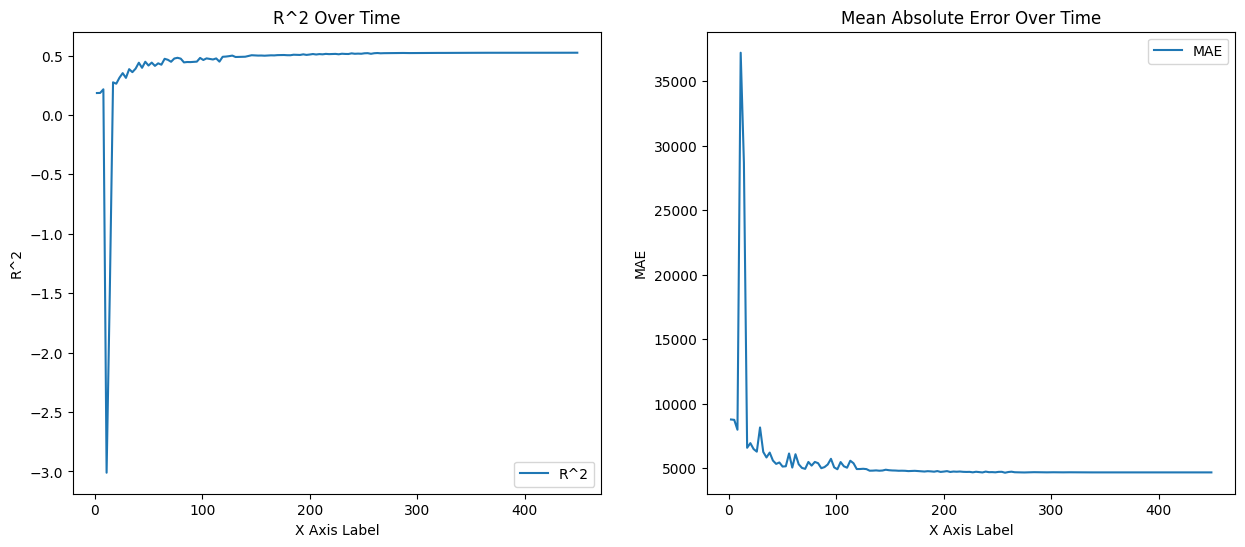

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R2
sns.lineplot(x='timesteps', y='r2', data=data, ax=axes[0])
axes[0].set_title('R^2 Over Time')
axes[0].set_xlabel('X Axis Label')
axes[0].set_ylabel('R^2')
axes[0].legend(labels=['R^2'])

# MAE
sns.lineplot(x='timesteps', y='mae', data=data, ax=axes[1])
axes[1].set_title('Mean Absolute Error Over Time')
axes[1].set_xlabel('X Axis Label')
axes[1].set_ylabel('MAE')
axes[1].legend(labels=['MAE'])
print("Max mean R2:", data.r2.max())
print("Min mean MAE:", data.mae.min())

plt.show()

Как на CV, так и без него, по графику можно видеть, что модель обучается с некоторой нестабильностью (до первого уменьшения lr'а на графике есть высокий пик) и имеет средний скор, схожий с RandomForest'ом. 

#### Анализ модели

Все метрики мониторились в tensorboard. В среднем одна модель (без CV) тоже примерно одинакова с RandomForest'ом по метрикам.

Max R2: 0.4797024726867676
Min MAE: 4373.65966796875


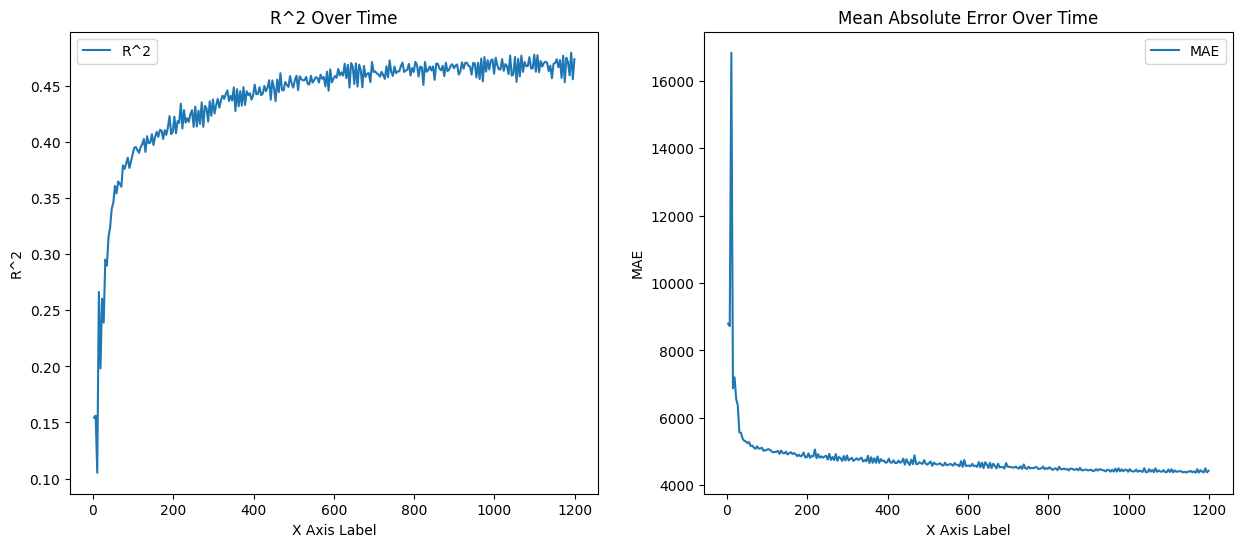

In [110]:
valr2 = pd.read_csv("r2_43.csv")
valmae = pd.read_csv("mae_43.csv")

valmae = valmae.rename({"Value": "val_mae"}, axis=1)
valmae['val_r2'] = valr2['Value']
valmae = valmae.drop(columns=['Wall time'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R2
sns.lineplot(x='Step', y='val_r2', data=valmae, ax=axes[0])
axes[0].set_title('R^2 Over Time')
axes[0].set_xlabel('X Axis Label')
axes[0].set_ylabel('R^2')
axes[0].legend(labels=['R^2'])

# MAE
sns.lineplot(x='Step', y='val_mae', data=valmae, ax=axes[1])
axes[1].set_title('Mean Absolute Error Over Time')
axes[1].set_xlabel('X Axis Label')
axes[1].set_ylabel('MAE')
axes[1].legend(labels=['MAE'])
print("Max R2:", valmae.val_r2.max())
print("Min MAE:", valmae.val_mae.min())

plt.show()

Точно также в случае увеличения окна для прогноза (с 14 до 25), увеличиваются метрики модели. Хотя в таком случае она уже проигрывает случайному лесу, вероятнее всего здесь уже нужен более точный файнтюнинг или просто не повезло со случайными числами, CV на разных значениях окон я не проводил т.к. долго по времени. 

Max R2: 0.5408681035041809
Min MAE: 3906.08056640625


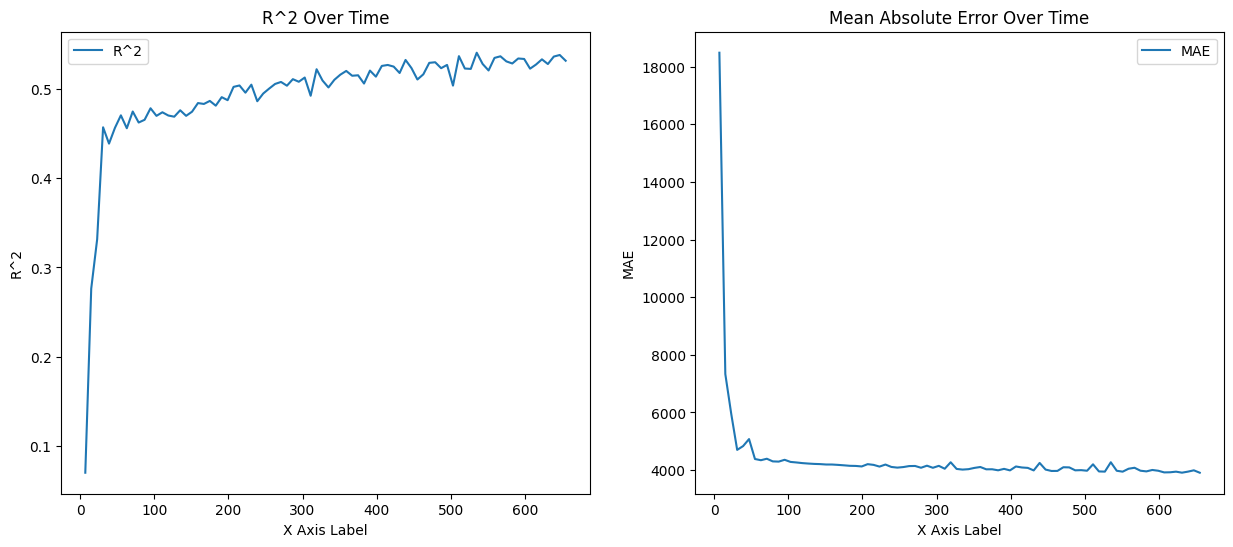

In [49]:
valr2 = pd.read_csv("r2_v.csv")
valmae = pd.read_csv("mae_v.csv")

valmae = valmae.rename({"Value": "val_mae"}, axis=1)
valmae['val_r2'] = valr2['Value']
valmae = valmae.drop(columns=['Wall time'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R2
sns.lineplot(x='Step', y='val_r2', data=valmae, ax=axes[0])
axes[0].set_title('R^2 Over Time')
axes[0].set_xlabel('X Axis Label')
axes[0].set_ylabel('R^2')
axes[0].legend(labels=['R^2'])

# MAE
sns.lineplot(x='Step', y='val_mae', data=valmae, ax=axes[1])
axes[1].set_title('Mean Absolute Error Over Time')
axes[1].set_xlabel('X Axis Label')
axes[1].set_ylabel('MAE')
axes[1].legend(labels=['MAE'])
print("Max R2:", valmae.val_r2.max())
print("Min MAE:", valmae.val_mae.min())

plt.show()

На какие фичи наиболее часто смотрит модель? Модель почти всегда уделяет колонке `sum_rub_service` наибольшие веса, потому что по-сути она напрямую влияет на стоимость сессии. Ради интереса я проверял на нескольких запусках, результат был одинаковый. Интересно что service_rownum имеет отрицательные веса, но также высокие.

In [113]:
# Модель не переключаем в .eval(), т.к. cuda RNN не поддерживает backprop в режиме eval'а
model = model.to("cpu")
model_check = copy.deepcopy(model)
model_check = model_check.to("cuda")

new_loader = DataLoader(train_dataset, batch_size=250, shuffle=False) # или pl_model.val_dataloader()

input_data, target_labels = next(iter(new_loader))
input_data = input_data.to("cuda")
target_labels = target_labels.to("cuda")

ig = IntegratedGradients(model_check.forward)

with torch.no_grad():
    for param in model.parameters():
        param.requires_grad = False

attributions, _ = ig.attribute(input_data, return_convergence_delta=True)

In [114]:
average_across_both = attributions.mean(dim=[0, 1])
average_across_both = average_across_both.to("cpu")

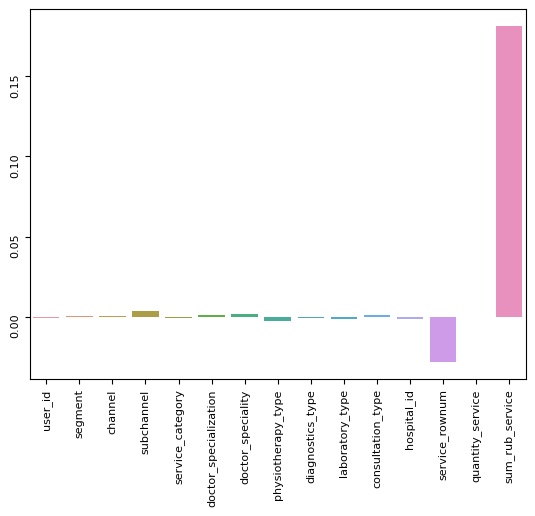

In [116]:
b = sns.barplot(pd.DataFrame([[it.item() for it in average_across_both]], columns=df.drop(columns=[*date_cols,
                                                           'session_id',
                                                           'session_length',
                                                           'session_status',]).columns))
b.tick_params(labelsize=8, rotation=90)

Однако же, если мы тренируем модель, убирая эту фичу (и `service_rownum` тоже, т.к. иначе он взлетает в космос по важности), модель начинает уделять примерно равномерное внимание остальным признакам.

Поэтому можно сказать, что в целом для RNN-модели (исключая `sum_rub_service` и `service_rownum`) наиболее важные признаки, в разрезе time-series данных, это: 
- service_category 
- subchannel
- diagnostics_type
- doctor_specialization
- laboratory_type

В целом по ним объяснение примерно такое же, как было у RandomForest'а, тут многие признаки совпадают. Разве что модель почти не смотрит на `hospital_id` и `user_id`

In [159]:
model = model.to("cpu")
model_check = copy.deepcopy(model)
model_check = model_check.to("cuda")

new_loader = DataLoader(train_dataset, batch_size=500, shuffle=False) # or pl_model.val_dataloader()

# Select a batch of data
input_data, target_labels = next(iter(new_loader))
input_data = input_data.to("cuda") # Move to the device where the model is
target_labels = target_labels.to("cuda")

# Create an IntegratedGradients object using your model's forward method
ig = IntegratedGradients(model_check.forward)

# Compute attributions for a specific target
#target = target_labels[0] # Select the target based on your specific task
with torch.no_grad():
    for param in model.parameters():
        param.requires_grad = False

attributions2, _ = ig.attribute(input_data, return_convergence_delta=True)
average_across_both2 = attributions2.mean(dim=[0, 1])
average_across_both2 = average_across_both2.to("cpu")

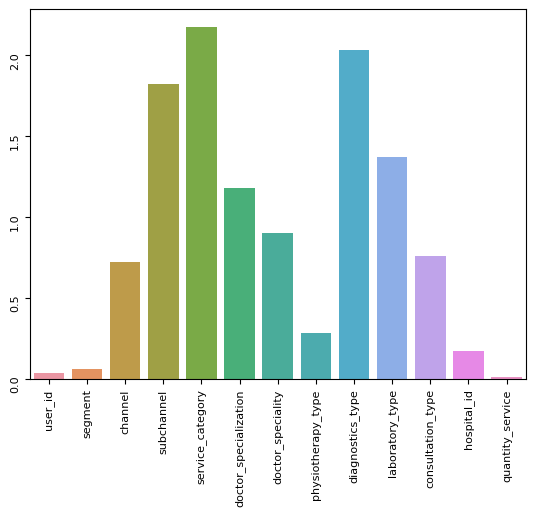

In [169]:
b = sns.barplot(pd.DataFrame([[it.item() for it in average_across_both2]], columns=df.drop(columns=[*date_cols,
                                                           'sum_rub_service',
                                                           'session_id',
                                                           'session_length',
                                                           'session_status',
                                                            'service_rownum']).columns))
b.tick_params(labelsize=8, rotation=90)

### Выводы

На основании работы с данными, можно сделать следующие выводы:
1. Данные очень зашумленные, много выбросов, есть сильный скос в сторону более дорогих сессий
2. Из-за сильного скоса в сторону дорогих сессий, прогнозирование таковых более затруднительно. Для этого нужно увеличивать окно лага (в случае с RandomForest) или количество таймстепов (в случае с RNN), что увеличивает количество вычислений.
3. И RNN и RandomForest выбрали почти одинаковые важные признаки для себя, пересекающиеся между ними:
    - sum_rub_service
    - doctor_specialization
    - laboratory_type
    - diagnostics_type<br>
4. RNN склонно выбирать более "общие" признаки, которые говорят в целом о характере услуги (`service_category`, `channel`, `consultation_type`, etc.) в то время как случайный лес чаще всего больше смотрит на пациента `user_id` и на больницу `hospital_id`, что говорит о том, что если появятся какие-то новые данные по пациентам или больницам, которых ранее не было, вероятнее всего случайный лес будет справляться хуже
5. В текущем состоянии обе модели показывают достаточно неплохие метрики - если занятся файнтюнингом или обучением бустинга и увеличить окно хотя бы до 20-и, то вполне возможно получить например R2 в 0.7-0.8. Если же увеличить окно до максимума (одна из сессий имеет какое-то космическое количество услуг в 1500+ при учёте что медиана это 5), то думаю что вполне возможно что скор сам по-себе будет очень высоким. Однако обучаться всё это будет чрезвычайно долго (хотя не отрицаю, что можно не делать паддинг для RNN, чего нельзя сказать про случайный лес).  